# Regresión Lineal Múltiple: Correlación, VIF y Regularización

En este ejercicio trabajaremos con el dataset de Boston Housing para:

1. **Estudiar la correlación entre variables**
2. **Calcular el VIF (Variance Inflation Factor)** de cada variable
3. **Analizar el impacto de eliminar variables correlacionadas** en las métricas del modelo
4. **Aplicar regularización L1 (Lasso) y L2 (Ridge)** y analizar sus efectos
5. **Interpretar los resultados** de las diferentes técnicas

## Importar las librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Cargar y explorar el dataset

In [3]:
# Cargar el dataset de Boston Housing
dataset = pd.read_csv('../data/BostonHousing.csv')

# Mostrar información básica del dataset
print("Dimensiones del dataset:", dataset.shape)
print("\nPrimeras 5 filas:")
dataset.head()

Dimensiones del dataset: (506, 14)

Primeras 5 filas:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# Información sobre las variables del dataset
print("Información del dataset:")
dataset.info()

print("\nEstadísticas descriptivas:")
dataset.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB

Estadísticas descriptivas:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Descripción de las variables:

- **CRIM**: Tasa de criminalidad per cápita por ciudad
- **ZN**: Proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados
- **INDUS**: Proporción de acres de negocios no minoristas por ciudad
- **CHAS**: Variable binaria del río Charles (1 si limita con el río, 0 en caso contrario)
- **NOX**: Concentración de óxidos nítricos (partes por 10 millones)
- **RM**: Número promedio de habitaciones por vivienda
- **AGE**: Proporción de unidades ocupadas por el propietario construidas antes de 1940
- **DIS**: Distancias ponderadas a cinco centros de empleo de Boston
- **RAD**: Índice de accesibilidad a las autopistas radiales
- **TAX**: Tasa de impuesto a la propiedad de valor completo por $10,000
- **PTRATIO**: Relación alumno-maestro por ciudad
- **B**: 1000(Bk - 0.63)^2 donde Bk es la proporción de personas de raza negra por ciudad
- **LSTAT**: % de estatus socioeconómico más bajo de la población
- **MEDV**: Valor mediano de las viviendas ocupadas por el propietario en $1000s (VARIABLE OBJETIVO)

## 1. Análisis de Correlación entre Variables

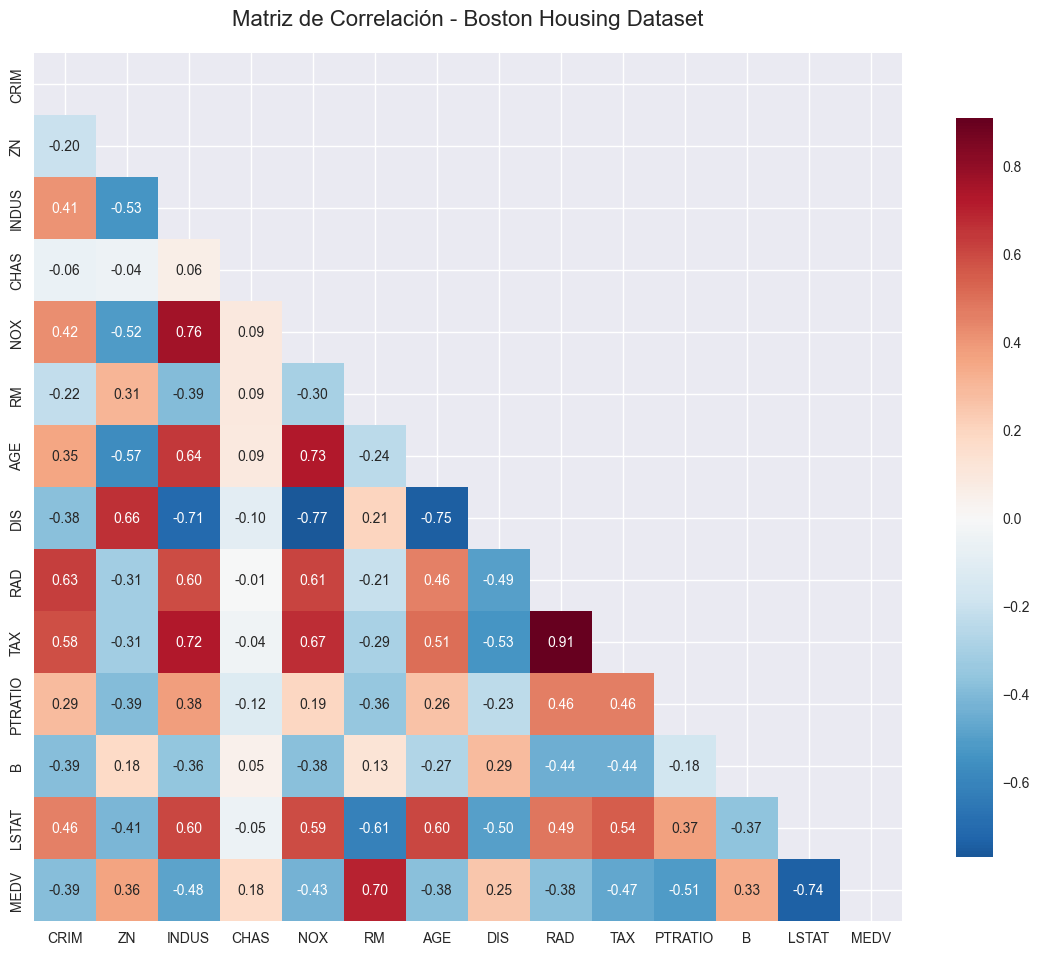

In [5]:
# Calcular la matriz de correlación
correlation_matrix = dataset.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Boston Housing Dataset', fontsize=16, pad=20)
plt.show()

In [6]:
# Identificar correlaciones altas (> 0.7 o < -0.7) excluyendo la diagonal
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlación': correlation_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
if not high_corr_df.empty:
    high_corr_df = high_corr_df.sort_values('Correlación', key=abs, ascending=False)
    print("Pares de variables con correlación alta (|r| > 0.7):")
    print(high_corr_df)
else:
    print("No se encontraron correlaciones altas (|r| > 0.7)")

Pares de variables con correlación alta (|r| > 0.7):
  Variable 1 Variable 2  Correlación
6        RAD        TAX     0.910228
4        NOX        DIS    -0.769230
0      INDUS        NOX     0.763651
5        AGE        DIS    -0.747881
7      LSTAT       MEDV    -0.737663
3        NOX        AGE     0.731470
2      INDUS        TAX     0.720760
1      INDUS        DIS    -0.708027


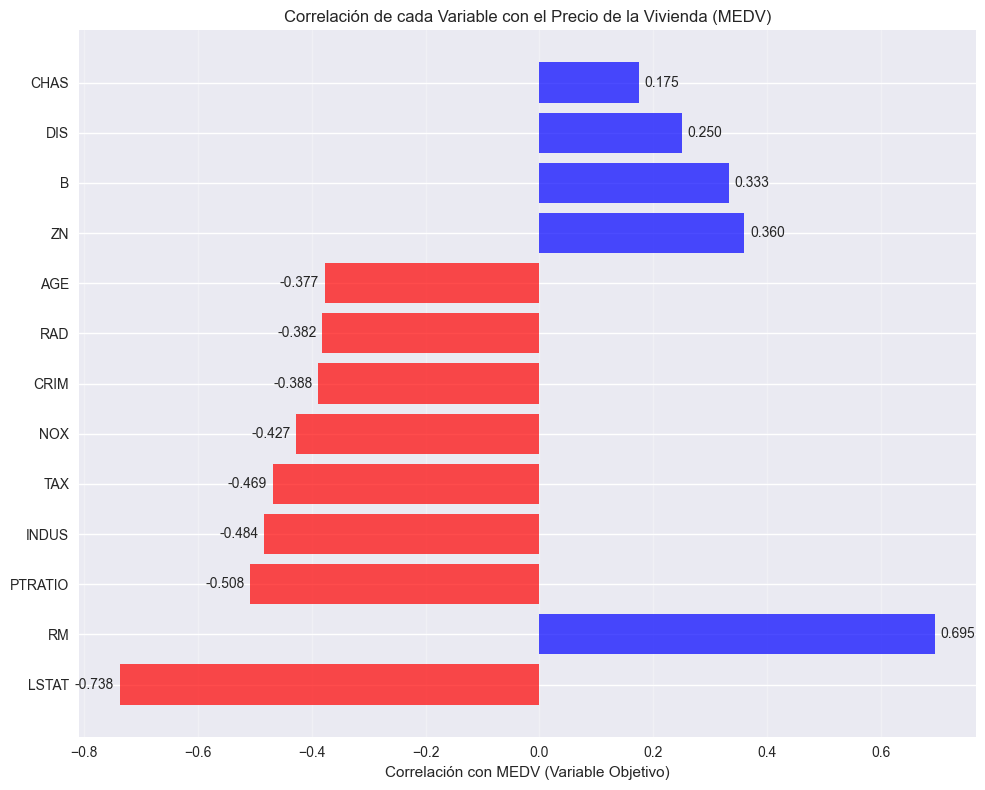


Correlaciones con la variable objetivo (MEDV):
LSTAT     -0.737663
RM         0.695360
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64


In [7]:
# Correlación de cada variable con la variable objetivo (MEDV)
target_correlation = correlation_matrix['MEDV'].drop('MEDV').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'blue' for x in target_correlation.values]
plt.barh(range(len(target_correlation)), target_correlation.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_correlation)), target_correlation.index)
plt.xlabel('Correlación con MEDV (Variable Objetivo)')
plt.title('Correlación de cada Variable con el Precio de la Vivienda (MEDV)')
plt.grid(axis='x', alpha=0.3)
for i, v in enumerate(target_correlation.values):
    plt.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
             va='center', ha='left' if v > 0 else 'right')
plt.tight_layout()
plt.show()

print("\nCorrelaciones con la variable objetivo (MEDV):")
print(target_correlation)

## 2. Cálculo del VIF (Variance Inflation Factor)

In [8]:
# Preparar los datos para el cálculo del VIF
X = dataset.drop('MEDV', axis=1)
y = dataset['MEDV']

# Agregar constante para el cálculo del VIF
X_with_const = sm.add_constant(X)

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1) 
                   for i in range(len(X.columns))]

# Ordenar por VIF descendente
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Factor de Inflación de la Varianza (VIF) para cada variable:")
print(vif_data)
print("\nInterpretación del VIF:")
print("- VIF = 1: No hay multicolinealidad")
print("- VIF > 5: Multicolinealidad moderada")
print("- VIF > 10: Multicolinealidad severa")

Factor de Inflación de la Varianza (VIF) para cada variable:
   Variable       VIF
9       TAX  9.008554
8       RAD  7.484496
4       NOX  4.393720
2     INDUS  3.991596
7       DIS  3.955945
6       AGE  3.100826
12    LSTAT  2.941491
1        ZN  2.298758
5        RM  1.933744
10  PTRATIO  1.799084
0      CRIM  1.792192
11        B  1.348521
3      CHAS  1.073995

Interpretación del VIF:
- VIF = 1: No hay multicolinealidad
- VIF > 5: Multicolinealidad moderada
- VIF > 10: Multicolinealidad severa


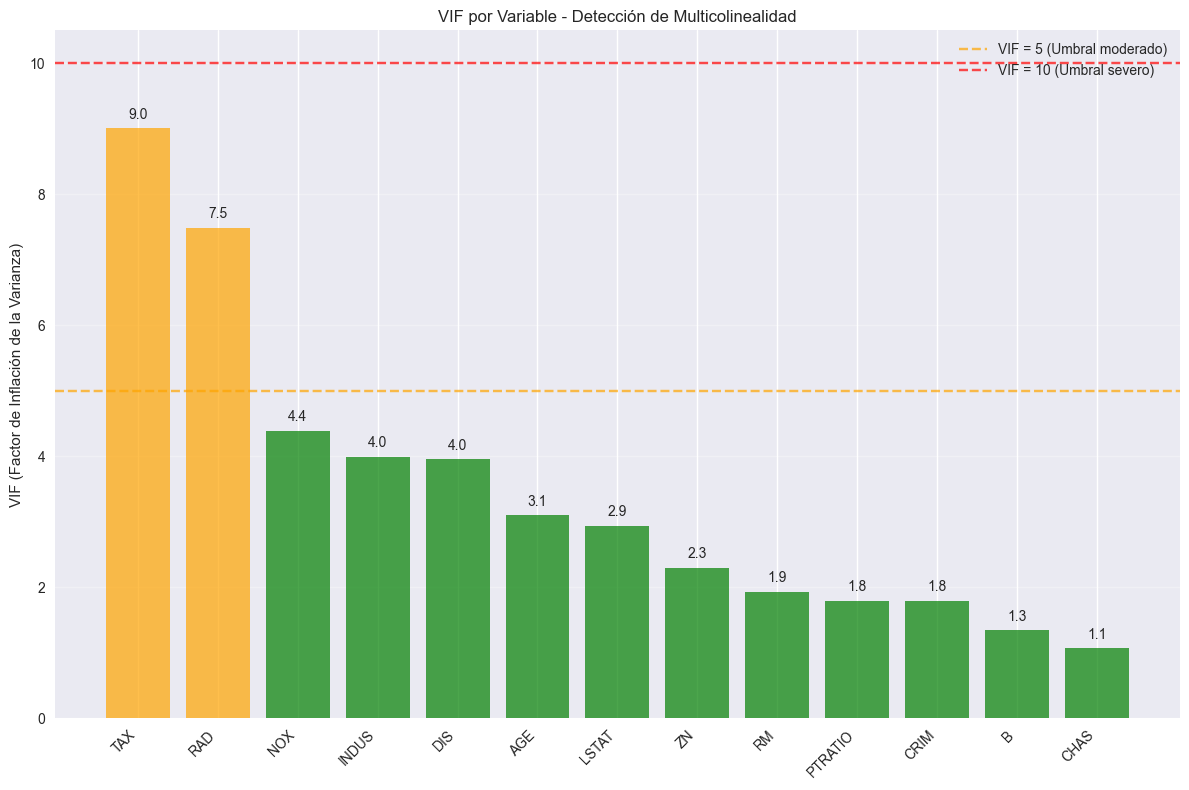

In [9]:
# Visualizar los valores de VIF
plt.figure(figsize=(12, 8))
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_data['VIF']]
bars = plt.bar(vif_data['Variable'], vif_data['VIF'], color=colors, alpha=0.7)
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='VIF = 5 (Umbral moderado)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='VIF = 10 (Umbral severo)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('VIF (Factor de Inflación de la Varianza)')
plt.title('VIF por Variable - Detección de Multicolinealidad')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bar, vif_val in zip(bars, vif_data['VIF']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{vif_val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Modelo de Referencia (Sin Eliminación de Variables)

In [10]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal múltiple
model_base = LinearRegression()
model_base.fit(X_train, y_train)

# Realizar predicciones
y_pred_base = model_base.predict(X_test)

# Calcular métricas del modelo base
mse_base = mean_squared_error(y_test, y_pred_base)
rmse_base = np.sqrt(mse_base)
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

print("=== MODELO BASE (Todas las variables) ===")
print(f"MSE: {mse_base:.3f}")
print(f"RMSE: {rmse_base:.3f}")
print(f"R²: {r2_base:.3f}")
print(f"MAE: {mae_base:.3f}")

# Almacenar métricas para comparación posterior
results_comparison = pd.DataFrame({
    'Modelo': ['Base (Todas las variables)'],
    'MSE': [mse_base],
    'RMSE': [rmse_base],
    'R²': [r2_base],
    'MAE': [mae_base],
    'Num_Variables': [X.shape[1]]
})

=== MODELO BASE (Todas las variables) ===
MSE: 24.291
RMSE: 4.929
R²: 0.669
MAE: 3.189


## 4. Eliminación de Variables con VIF Alto

In [ ]:
# Identificar variables con VIF > 10 para eliminar
high_vif_vars = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()

print(f"Variables con VIF > 10 a eliminar: {high_vif_vars}")

Variables con VIF > 10 a eliminar: []


In [ ]:
# Crear dataset sin las variables de VIF alto
X_reduced = X.drop(columns=high_vif_vars)

print(f"Número de variables después de eliminación: {X_reduced.shape[1]}")
print(f"Variables eliminadas: {set(X.columns) - set(X_reduced.columns)}")

Número de variables después de eliminación: 13
Variables eliminadas: set()


In [ ]:
# Recalcular VIF para el dataset reducido
X_reduced_with_const = sm.add_constant(X_reduced)
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Variable"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced_with_const.values, i+1) 
                           for i in range(len(X_reduced.columns))]

print("VIF después de eliminar variables problemáticas:")
print(vif_data_reduced)

VIF después de eliminar variables problemáticas:
   Variable       VIF
0      CRIM  1.792192
1        ZN  2.298758
2     INDUS  3.991596
3      CHAS  1.073995
4       NOX  4.393720
5        RM  1.933744
6       AGE  3.100826
7       DIS  3.955945
8       RAD  7.484496
9       TAX  9.008554
10  PTRATIO  1.799084
11        B  1.348521
12    LSTAT  2.941491


In [ ]:
# Entrenar modelo con variables reducidas
X_reduced_train, X_reduced_test, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

model_reduced = LinearRegression()
model_reduced.fit(X_reduced_train, y_train_reduced)

# Calcular métricas del modelo reducido
y_pred_reduced = model_reduced.predict(X_reduced_test)

mse_reduced = mean_squared_error(y_test_reduced, y_pred_reduced)
rmse_reduced = np.sqrt(mse_reduced)
r2_reduced = r2_score(y_test_reduced, y_pred_reduced)
mae_reduced = mean_absolute_error(y_test_reduced, y_pred_reduced)

print("=== MODELO REDUCIDO (Sin variables VIF alto) ===")
print(f"MSE: {mse_reduced:.3f}")
print(f"RMSE: {rmse_reduced:.3f}")
print(f"R²: {r2_reduced:.3f}")
print(f"MAE: {mae_reduced:.3f}")

=== MODELO REDUCIDO (Sin variables VIF alto) ===
MSE: 24.29111947497367
RMSE: 4.928602182665352
R²: 0.6687594935356299
MAE: 3.1890919658878656


In [ ]:
# Agregar resultados del modelo reducido a la comparación
new_row = pd.DataFrame({
    'Modelo': ['Reducido (Sin VIF alto)'],
    'MSE': [mse_reduced],
    'RMSE': [rmse_reduced],
    'R²': [r2_reduced],
    'MAE': [mae_reduced],
    'Num_Variables': [X_reduced.shape[1]]
})

results_comparison = pd.concat([results_comparison, new_row], ignore_index=True)
print("\nComparación de Modelos:")
print(results_comparison)


Comparación de Modelos:
                       Modelo        MSE      RMSE        R²       MAE  \
0  Base (Todas las variables)  24.291119  4.928602  0.668759  3.189092   
1     Reducido (Sin VIF alto)  24.291119  4.928602  0.668759  3.189092   
2     Reducido (Sin VIF alto)  24.291119  4.928602  0.668759  3.189092   

   Num_Variables  
0             13  
1             13  
2             13  


## 5. Regularización L1 (Lasso) y L2 (Ridge)

In [ ]:
# Estandarizar los datos para regularización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos estandarizados para regularización")
print(f"Media de X_train_scaled: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Std de X_train_scaled: {np.std(X_train_scaled, axis=0).round(3)}")

### 5.1 Regresión Ridge (L2)

In [ ]:
# Probar diferentes valores de alpha para Ridge
alpha_values = [0.1, 1, 10, 100, 1000]
ridge_results = []

for alpha in alpha_values:
    # Crear y entrenar modelo Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    
    # Hacer predicciones y calcular métricas
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    
    ridge_results.append({
        'Alpha': alpha,
        'MSE': mse_ridge,
        'R²': r2_ridge
    })

ridge_results_df = pd.DataFrame(ridge_results)
print("Resultados de Ridge Regression:")
print(ridge_results_df)

### 5.2 Regresión Lasso (L1)

In [ ]:
# Probar diferentes valores de alpha para Lasso
alpha_values_lasso = [0.01, 0.1, 1, 10, 100]
lasso_results = []

for alpha in alpha_values_lasso:
    # Crear y entrenar modelo Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Hacer predicciones y calcular métricas
    y_pred_lasso = lasso_model.predict(X_test_scaled)
    
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    
    # Contar variables seleccionadas (coeficientes no cero)
    selected_features = np.sum(lasso_model.coef_ != 0)
    
    lasso_results.append({
        'Alpha': alpha,
        'MSE': mse_lasso,
        'R²': r2_lasso,
        'Variables_Seleccionadas': selected_features
    })

lasso_results_df = pd.DataFrame(lasso_results)
print("Resultados de Lasso Regression:")
print(lasso_results_df)

### 5.3 Comparación Visual de Regularización

In [ ]:
# Crear gráficos comparativos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: MSE vs Alpha
ax1.plot(ridge_results_df['Alpha'], ridge_results_df['MSE'], 'o-', label='Ridge', color='blue')
ax1.plot(lasso_results_df['Alpha'], lasso_results_df['MSE'], 's-', label='Lasso', color='red')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (escala logarítmica)')
ax1.set_ylabel('MSE')
ax1.set_title('MSE vs Alpha')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: R² vs Alpha  
ax2.plot(ridge_results_df['Alpha'], ridge_results_df['R²'], 'o-', label='Ridge', color='blue')
ax2.plot(lasso_results_df['Alpha'], lasso_results_df['R²'], 's-', label='Lasso', color='red')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (escala logarítmica)')
ax2.set_ylabel('R²')
ax2.set_title('R² vs Alpha')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4 Análisis de Coeficientes

In [ ]:
# Seleccionar mejores alphas y comparar coeficientes
best_ridge_alpha = ridge_results_df.loc[ridge_results_df['R²'].idxmax(), 'Alpha']
best_lasso_alpha = lasso_results_df.loc[lasso_results_df['R²'].idxmax(), 'Alpha']

# Entrenar modelos finales
final_ridge = Ridge(alpha=best_ridge_alpha)
final_lasso = Lasso(alpha=best_lasso_alpha)

final_ridge.fit(X_train_scaled, y_train)
final_lasso.fit(X_train_scaled, y_train)

# Comparar coeficientes
coefficients_comparison = pd.DataFrame({
    'Variable': X.columns,
    'Linear_Regression': model_base.coef_,
    'Ridge': final_ridge.coef_,
    'Lasso': final_lasso.coef_
})

print("Comparación de coeficientes:")
print(coefficients_comparison.round(3))

In [ ]:
# Visualizar coeficientes
plt.figure(figsize=(14, 8))
x_pos = np.arange(len(X.columns))
width = 0.25

plt.bar(x_pos - width, coefficients_comparison['Linear_Regression'], width, 
        label='Linear Regression', alpha=0.8)
plt.bar(x_pos, coefficients_comparison['Ridge'], width, 
        label='Ridge', alpha=0.8)
plt.bar(x_pos + width, coefficients_comparison['Lasso'], width, 
        label='Lasso', alpha=0.8)

plt.title('Comparación de Coeficientes: Linear vs Ridge vs Lasso')
plt.xlabel('Variables')
plt.ylabel('Valor del Coeficiente')
plt.xticks(x_pos, X.columns, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Comparación Final de Modelos

In [ ]:
# Agregar resultados de regularización a la comparación
# Predicciones de modelos regularizados
y_pred_ridge_final = final_ridge.predict(X_test_scaled)
y_pred_lasso_final = final_lasso.predict(X_test_scaled)

# Métricas de Ridge
mse_ridge_final = mean_squared_error(y_test, y_pred_ridge_final)
r2_ridge_final = r2_score(y_test, y_pred_ridge_final)
rmse_ridge_final = np.sqrt(mse_ridge_final)
mae_ridge_final = mean_absolute_error(y_test, y_pred_ridge_final)

# Métricas de Lasso  
mse_lasso_final = mean_squared_error(y_test, y_pred_lasso_final)
r2_lasso_final = r2_score(y_test, y_pred_lasso_final)
rmse_lasso_final = np.sqrt(mse_lasso_final)
mae_lasso_final = mean_absolute_error(y_test, y_pred_lasso_final)

# Agregar a comparación
ridge_row = pd.DataFrame({
    'Modelo': [f'Ridge (α={best_ridge_alpha})'],
    'MSE': [mse_ridge_final],
    'RMSE': [rmse_ridge_final],
    'R²': [r2_ridge_final],
    'MAE': [mae_ridge_final],
    'Num_Variables': [X.shape[1]]  # Ridge no elimina variables
})

lasso_row = pd.DataFrame({
    'Modelo': [f'Lasso (α={best_lasso_alpha})'],
    'MSE': [mse_lasso_final],
    'RMSE': [rmse_lasso_final],
    'R²': [r2_lasso_final],
    'MAE': [mae_lasso_final],
    'Num_Variables': [np.sum(final_lasso.coef_ != 0)]
})

results_comparison = pd.concat([results_comparison, ridge_row, lasso_row], ignore_index=True)

In [ ]:
# Mostrar comparación final
print("=== COMPARACIÓN FINAL DE MODELOS ===")
print(results_comparison.round(3))

# Identificar el mejor modelo
best_model_idx = results_comparison['R²'].idxmax()
best_model = results_comparison.loc[best_model_idx, 'Modelo']
best_r2 = results_comparison.loc[best_model_idx, 'R²']

print(f"\nMejor modelo basado en R²: {best_model} (R² = {best_r2:.3f})")

In [ ]:
# Crear visualización de comparación de modelos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

models = results_comparison['Modelo']

# MSE
ax1.bar(models, results_comparison['MSE'], alpha=0.7, color='red')
ax1.set_title('MSE por Modelo')
ax1.set_ylabel('MSE')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# RMSE
ax2.bar(models, results_comparison['RMSE'], alpha=0.7, color='orange')
ax2.set_title('RMSE por Modelo')
ax2.set_ylabel('RMSE')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# R²
ax3.bar(models, results_comparison['R²'], alpha=0.7, color='green')
ax3.set_title('R² por Modelo')
ax3.set_ylabel('R²')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# MAE
ax4.bar(models, results_comparison['MAE'], alpha=0.7, color='blue')
ax4.set_title('MAE por Modelo')
ax4.set_ylabel('MAE')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Rendimiento de Modelos', fontsize=16)
plt.tight_layout()
plt.show()